In [1]:
from typing import List, Mapping
from itertools import zip_longest
from glob import iglob

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

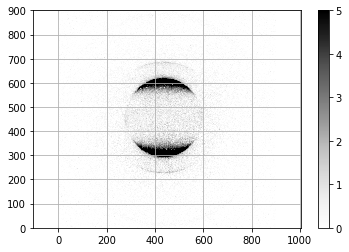

In [10]:
globbed = iglob("/data/Test/Run_019/work/reduced_dt=-6.05.h5")

with File(next(globbed), "r") as f:
    img = f["df_img"][...].T

plt.figure()
plt.pcolormesh(img.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 5)
plt.show()

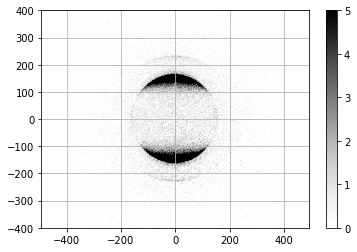

In [14]:
xn, yn = img.shape
xedges = np.arange(xn + 1)
yedges = np.arange(yn + 1)
f = interp(img, xedges, yedges)
g = transpose_linearly(f, np.eye(2), x0=np.array([440, 455]))
zedges = np.arange(-400, 400 + 1)
transformed = tohist(g, zedges, zedges)

plt.figure()
plt.pcolormesh(zedges, zedges, transformed.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 5)
plt.show()

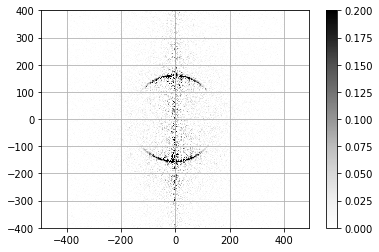

In [15]:
# Abel invert the image
dz = zedges[1:] - zedges[:-1]
inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)

plt.figure()
plt.pcolormesh(zedges, zedges, inverted.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 0.2)
plt.show()

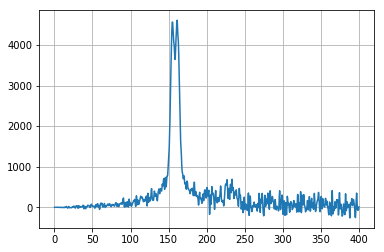

In [16]:
# Transpose to other spaces
sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
redges, thedges = np.linspace(0, 400, 801), np.linspace(-np.pi, np.pi, 721)
hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
_, coeff, _ = finite_legendre_transform_in_theta(
    hist_indrdomega.sum(0), thedges, 6,
)  # Shapes of returns: (n, r) (n, r) (n, th)

plt.figure()
plt.plot((redges[1:] + redges[:-1]) / 2, hist_indrdth.sum(1))
plt.grid()
plt.show()